In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive/')

# FOLDERNAME = 'ex3_302168687_200409159'
sys.path.append('/content/drive/MyDrive')
# sys.path.append('/content/drive/My Drive/{}/Q4'.format(FOLDERNAME))
%cd /content/drive/MyDrive
time_test=True
# %load_ext autoreload
# %autoreload 2

Mounted at /content/drive/
/content/drive/MyDrive


Imports

In [2]:
!pip install torch # ==1.7.0+cu101
!pip install torchaudio==0.7.0
!pip install torchvision==0.8.0
!pip install soundfile

     |████████████████████████████████| 7.6MB 4.5MB/s 
     |████████████████████████████████| 776.8MB 20kB/s 
ERROR: torchvision 0.8.2+cu101 has requirement torch==1.7.1, but you'll have torch 1.7.0 which is incompatible.
  Found existing installation: torch 1.7.1+cu101
    Uninstalling torch-1.7.1+cu101:
      Successfully uninstalled torch-1.7.1+cu101
     |████████████████████████████████| 11.8MB 130kB/s 
  Found existing installation: torchvision 0.8.2+cu101
    Uninstalling torchvision-0.8.2+cu101:
      Successfully uninstalled torchvision-0.8.2+cu101


In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, models, transforms
import torchaudio

import os
import matplotlib
import pylab
import librosa
import numpy as np

import soundfile as sf

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

#!apt-get install sox libsox-dev libsox-fmt-all
#!pip install git+git://github.com/pytorch/audio
from IPython.display import Audio

from scipy.io import wavfile
from librosa.feature import mfcc
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 

import os
import pandas as pd
import random

from pathlib import Path

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Model architectures

In [4]:
class MonoCnnAudioNet(nn.Module):
    def __init__(self,numClasses):
        super(MonoCnnAudioNet,self).__init__()
        self.num_classes = numClasses
        self.fc_features = 128
        self.C1 = nn.Conv2d(1,32,3,padding=1)
        self.C11 = nn.Conv2d(32,32,3,padding=1)
        self.C2 = nn.Conv2d(32,64,3,padding=1)
        self.C22 = nn.Conv2d(64,64,3,padding=1)
        self.C3 = nn.Conv2d(64,128,3,padding=1)
        self.C33 = nn.Conv2d(128,128,3,padding=1)
        
        self.BN1 = nn.BatchNorm2d(32)
        self.BN11 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN22 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN33 = nn.BatchNorm2d(128)
        
        self.BNFC = nn.BatchNorm1d(self.fc_features)
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.maxpool2 = nn.MaxPool2d((2,2),(2,2))
        self.softmax = nn.Softmax(dim=1)
        
        self.flatten = torch.nn.Flatten()

        # self.fc1 = nn.Linear(64*32*32,self.fc_features)
        self.fc1 = nn.Linear(512,self.fc_features)
        self.fc2 = nn.Linear(self.fc_features, 1) 
        
        self.dropout = nn.Dropout(0.35)

        self.BNout = nn.BatchNorm1d(1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self,x,extra_feature):
        # add sequence of convolutional and max pooling layers
        x = self.maxpool1(F.relu(self.BN1(self.C1(x))))
        x = self.maxpool1(F.relu(self.BN11(self.C11(x)))) ##
        x = self.dropout(x)                                 ## @@
        x = self.maxpool1(F.relu(self.BN2(self.C2(x))))     
        x = self.maxpool1(F.relu(self.BN22(self.C22(x)))) ##
        # x = F.relu(self.BN3(self.C3(x)))                  ##
        # x = self.dropout(x)                                 ## @@  
        x = self.maxpool1(F.relu(self.BN3(self.C3(x))))     ## @@
        x = self.maxpool1(F.relu(self.BN33(self.C33(x)))) ##

        # flatten image input
        # x = x.view(-1,64*32*32)
        x = self.flatten(x)

        x = self.BNFC(self.fc1(x))
        x = self.dropout(x)
        if not time_test:
          x = torch.cat((x, extra_feature/240), 1) #normalize extra_feature
          x = self.fc2(x)
        else:
          # x = torch.cat((x, (extra_feature-2)/100), 1) #normalize extra_feature
          x = self.fc2(x)
          x = self.BNout(x)
          x = self.sigmoid(x) * 1440
          # x = (1+self.tanh(x))/2*1440
        #x = self.softmax(x) #already included in CrossEntropyLoss
        return x
        
class EncodedCnnAudioNet(nn.Module):
    def __init__(self,numClasses):
        super(EncodedCnnAudioNet,self).__init__()
        self.num_classes = numClasses
        self.fc_features = 128
        self.C1 = nn.Conv2d(3,32,3,padding=1)
        self.C11 = nn.Conv2d(32,32,3,padding=1)
        self.C2 = nn.Conv2d(32,64,3,padding=1)
        self.C22 = nn.Conv2d(64,64,3,padding=1)
        self.C3 = nn.Conv2d(64,128,3,padding=1)
        self.C33 = nn.Conv2d(128,128,3,padding=1)
        
        self.BN1 = nn.BatchNorm2d(32)
        self.BN11 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN22 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN33 = nn.BatchNorm2d(128)

        self.BNFC = nn.BatchNorm1d(self.fc_features)
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.maxpool2 = nn.MaxPool2d((2,2),(2,2))
        self.softmax = nn.Softmax(dim=1)
        
        self.flatten = torch.nn.Flatten()
        
        # self.fc1 = nn.Linear(64*32*32,self.fc_features)
        # self.fc2 = nn.Linear(self.fc_features + 1,self.num_classes) 
        self.fc1 = nn.Linear(512,self.fc_features)
        self.fc2 = nn.Linear(self.fc_features, 1) 
        self.dropout = nn.Dropout(0.35)

        self.BNout = nn.BatchNorm1d(1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self,x,extra_feature):
        # add sequence of convolutional and max pooling layers
        x = self.maxpool1(F.relu(self.BN1(self.C1(x))))
        x = self.maxpool1(F.relu(self.BN11(self.C11(x))))
        x = self.maxpool1(F.relu(self.BN2(self.C2(x))))
        x = self.maxpool1(F.relu(self.BN22(self.C22(x))))
        x = self.maxpool1(F.relu(self.BN3(self.C3(x))))
        x = self.maxpool1(F.relu(self.BN33(self.C33(x))))
        # flatten image input
        x = self.flatten(x)
        x =  self.BNFC(self.fc1(x))
        x = self.dropout(x)
        if not time_test:
          x = torch.cat((x, extra_feature/240), 1) #normalize extra_feature
          x = self.fc2(x)
        else:
          # x = torch.cat((x, (extra_feature-2)/100), 1) #normalize extra_feature
          x = self.fc2(x)
          x = self.BNout(x)
          x = self.sigmoid(x) * 1440
        #x = self.softmax(x) #already included in CrossEntropyLoss
        return x

class HPSSCnnAudioNet(nn.Module):
    def __init__(self,numClasses):
        super(HPSSCnnAudioNet,self).__init__()
        self.num_classes = numClasses
        self.fc_features = 64
        self.C1 = nn.Conv2d(2,32,3,padding=1)
        self.C11 = nn.Conv2d(32,32,3,padding=1)
        self.C2 = nn.Conv2d(32,64,3,padding=1)
        self.C22 = nn.Conv2d(64,64,3,padding=1)
        self.C3 = nn.Conv2d(64,128,3,padding=1)
        self.C33 = nn.Conv2d(128,128,3,padding=1)
        
        self.BN1 = nn.BatchNorm2d(32)
        self.BN11 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN22 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN33 = nn.BatchNorm2d(128)

        self.BNFC = nn.BatchNorm1d(self.fc_features)
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.maxpool2 = nn.MaxPool2d((2,2),(2,2))
        self.softmax = nn.Softmax(dim=1)
        
        self.flatten = torch.nn.Flatten()
        
        # self.fc1 = nn.Linear(64*32*32,self.fc_features)
        # self.fc2 = nn.Linear(self.fc_features + 1,self.num_classes) 
        self.fc1 = nn.Linear(1152,self.fc_features)
        self.fc2 = nn.Linear(self.fc_features, 1) 
        self.dropout = nn.Dropout(0.35)

        self.BNout = nn.BatchNorm1d(1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
  
    def forward(self,x,extra_feature):
        # add sequence of convolutional and max pooling layers
        x = self.maxpool1(F.relu(self.BN1(self.C1(x))))
        x = self.maxpool1(F.relu(self.BN11(self.C11(x))))
        x = self.maxpool1(F.relu(self.BN2(self.C2(x))))
        x = self.maxpool1(F.relu(self.BN22(self.C22(x))))
        x = self.maxpool1(F.relu(self.BN3(self.C3(x))))
        x = self.maxpool1(F.relu(self.BN33(self.C33(x))))
        # flatten image input
        x = x.view(-1,1152)
        x =  self.BNFC(self.fc1(x))
        x = self.dropout(x)
        if not time_test:
          x = torch.cat((x, extra_feature/240), 1) #normalize extra_feature
          x = self.fc2(x)
        else:
          # x = torch.cat((x, (extra_feature-2)/100), 1) #normalize extra_feature
          x = self.fc2(x)
          x = self.BNout(x)
          x = self.sigmoid(x) * 1440
        #x = self.softmax(x) #already included in CrossEntropyLoss
        return x
        
        
class EnsembleCnnAudioNet(nn.Module):
    def __init__(self, numClasses, mono_model, mono_acc, mono_weights,
                 encoded_model, encoded_acc, encoded_weights, 
                 hpss_model, hpss_acc, hpss_weights):
        super(EnsembleCnnAudioNet,self).__init__()
        self.num_classes = numClasses
        self.mono_model = mono_model
        self.mono_weights = mono_weights
        self.mono_acc = mono_acc
        self.encoded_model = encoded_model
        self.encoded_weights = encoded_weights
        self.encoded_acc = encoded_acc
        self.hpss_model = hpss_model
        self.hpss_weights = hpss_weights
        self.hpss_acc = hpss_acc
        self.alpha = 2

        
    def forward(self, mono, encoded, hpss, timestamp):
        output_mono = self.mono_model(mono,timestamp)
        
        output_encoded = self.encoded_model(encoded,timestamp)
        
        output_hpss = self.hpss_model(hpss,timestamp)
        
        # outP = torch.pow(mono_acc, 3) * (outP_mono * mono_weights) + \
        #         torch.pow(encoded_acc, 3) * (outP_encoded * encoded_weights) + \
        #         torch.pow(hpss_acc,  3) * (outP_hpss * hpss_weights)
        pow = 4
        outP = (torch.pow(mono_acc, pow) * (output_mono) + \
                torch.pow(encoded_acc, pow) * (output_encoded) + \
                torch.pow(hpss_acc,  pow) * (output_hpss))/(torch.pow(mono_acc, pow) + torch.pow(encoded_acc, pow) + torch.pow(hpss_acc,  pow))
        
        return outP


Utility functions

In [5]:
def loadModel(model, model_name, path):
    path = F"{path}/{model_name}.pt"
    model.load_state_dict(torch.load(path))
    return model

@torch.no_grad()
def calculateTestLoss(model, criterion, test_generator):
    model.eval()
    test_loss = 0
    Label_all = []
    Output_all = []
    for dataBatch,target,timestamp in test_generator:
        dataBatch, target, timestamp = dataBatch.float().cuda(), target.cuda(), timestamp.unsqueeze(1).cuda()
        output = model(dataBatch, timestamp)
        if not time_test:
          loss = criterion(output,torch.max(target.long(), 1)[1])
        else:
          # loss = min(criterion(output, target), criterion(output-1, target), criterion(output+1, target))
          loss = min(criterion(output, target), criterion(output-1440, target), criterion(output+1440, target))
        test_loss += loss.item()*dataBatch.size(0)
        Label_all.extend(target.tolist())
        Output_all.extend(output.tolist())

    x = np.abs(np.array(Label_all) - np.array(Output_all))
    y = 1440 - np.abs(np.array(Label_all) - np.array(Output_all))
    accuracy = (np.minimum(x,y)<=240).sum() / len(Label_all)
    # y = 1 - np.abs(np.array(Label_all) - np.array(Output_all))
    # accuracy = (np.minimum(x,y)<=(180/1440)).sum() / len(Label_all)

    return test_loss/len(test_generator), accuracy

Dataset

In [6]:
class Dataset(data.Dataset):
    def __init__(self, fileNames, locations, dataPath1, dataPath2, numClasses):
        'Initialization'
        self.locations = locations
        self.file_names = fileNames
        self.data_path1= dataPath1
        self.data_path2= dataPath2
        self.num_classes = numClasses
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_names)

    def __getitem__(self, index):
        'Generates one sample of data'
        file_name = self.file_names[index]
        location = self.locations[index]
        try:
          file_mono = os.path.join(self.data_path1, "Mono", str(location), str(file_name))
          Im_mono = torch.load(file_mono)
        except:
          file_mono = os.path.join(self.data_path2, "Mono", str(location), str(file_name))
          Im_mono = torch.load(file_mono)
        try:
          file_encoded = os.path.join(self.data_path1, "Encoded", str(location), str(file_name))
          Im_encoded = torch.load(file_encoded)
        except:
          file_encoded = os.path.join(self.data_path2, "Encoded", str(location), str(file_name))
          Im_encoded = torch.load(file_encoded)
        try:
          file_hpss = os.path.join(self.data_path1, "HPSS", str(location), str(file_name))
          Im_hpss = torch.load(file_hpss)
        except:
          file_hpss = os.path.join(self.data_path2, "HPSS", str(location), str(file_name))
          Im_hpss = torch.load(file_hpss)
        Im_encoded.requires_grad=False
        label_out = np.zeros(self.num_classes)
        label_out = torch.from_numpy(label_out).float()
        timestamp = file_name.split("_", 1)[1]
        timestamp = int(timestamp.split(".", 1)[0])/1000 # quantization of 30-minutes
        timestamp = torch.tensor(timestamp, dtype=torch.float32)
        #print(timestamp, Im.shape, label)
        if not time_test:
          label = location
          label_out[label-2] = 1
          extra_feature = timestamp
        else:
          label = (int(file_name[-9:-7])*60 + int(file_name[-7:-5])) # /1440
          label_out[0] = label
          extra_feature = location

        return Im_mono,Im_encoded,Im_hpss,label_out,extra_feature

Load dataset

In [7]:
spots_to_train = range(2,12)
random.seed(3)
num_classes = 1
path = '/content/drive/MyDrive/Project/Dataset'
path_csv = '/content/drive/MyDrive/project_new/copy/DataSet'
test_path_csv = '/content/drive/MyDrive/project_new/copy/TestSet'
test_path = '/content/drive/MyDrive/Project/Testset'
#Load train data
mono_labels = pd.read_csv(os.path.join(path_csv, "labels.csv"))
mono_test_labels = pd.read_csv(os.path.join(test_path_csv, "labels.csv"))
mono_labels = pd.concat([mono_labels, mono_test_labels])
sample_indexes = [mono_label in spots_to_train for mono_label in mono_labels['label']]
mono_labels = mono_labels[sample_indexes]
mono_n_samples = len(mono_labels)

encoded_labels = pd.read_csv(os.path.join(path_csv, "encoded_labels.csv"))
encoded_test_labels = pd.read_csv(os.path.join(test_path_csv, "encoded_labels.csv"))
encoded_labels = pd.concat([encoded_labels, encoded_test_labels])
sample_indexes = [encoded_label in spots_to_train for encoded_label in encoded_labels['label']]
encoded_labels = encoded_labels[sample_indexes]
encoded_n_samples = len(encoded_labels)


hpss_labels = pd.read_csv(os.path.join(path_csv, "hpss_labels.csv"))
hpss_test_labels = pd.read_csv(os.path.join(test_path_csv, "hpss_labels.csv"))
hpss_labels = pd.concat([hpss_labels, hpss_test_labels])
sample_indexes = [hpss_label in spots_to_train for hpss_label in hpss_labels['label']]
hpss_labels = hpss_labels[sample_indexes]
hpss_n_samples = len(hpss_labels)

n_samples = min(mono_n_samples, encoded_n_samples)
n_samples = min(n_samples, hpss_n_samples)


train_len = int(n_samples * 0.9)
valid_len = int(n_samples * 0.05)
test_len  = n_samples - train_len - valid_len
total_list = list(range(n_samples))
train_list = random.sample(total_list, train_len)
total_list = list(set(total_list)^set(train_list))
valid_list = random.sample(total_list, valid_len)
total_list = list(set(total_list)^set(valid_list))
test_list = random.sample(total_list, test_len)
mono_test_data = mono_labels.iloc[test_list]
mono_train_data = mono_labels.iloc[train_list]
mono_valid_data = mono_labels.iloc[valid_list]
encoded_test_data = encoded_labels.iloc[test_list]
encoded_train_data = encoded_labels.iloc[train_list]
encoded_valid_data = encoded_labels.iloc[valid_list]
hpss_test_data = hpss_labels.iloc[test_list]
hpss_train_data = hpss_labels.iloc[train_list]
hpss_valid_data = hpss_labels.iloc[valid_list]
train_data = pd.merge(hpss_train_data, encoded_train_data)
train_data = pd.merge(train_data, mono_train_data)
test_data = pd.merge(hpss_test_data, encoded_test_data)
test_data = pd.merge(test_data, mono_test_data)
valid_data = pd.merge(hpss_valid_data, encoded_valid_data)
valid_data = pd.merge(valid_data, mono_valid_data)



training_set = Dataset(train_data["filename"].tolist(), train_data["label"].tolist(), path, test_path, num_classes)
batch_size = 32
train_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
training_generator = data.DataLoader(training_set, **train_params)
#Load validation data
valid_set = Dataset(valid_data["filename"].tolist(), valid_data["label"].tolist(), path,  test_path, num_classes)
batch_size = 32
valid_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
valid_generator = data.DataLoader(valid_set, **valid_params)
#Load Test data
test_set = Dataset(test_data["filename"].tolist(), test_data["label"].tolist(), path,  test_path, num_classes)
batch_size = 32
test_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
test_generator = data.DataLoader(test_set, **test_params)

print("Training set contains " + str(train_len) + " samples")
print("Validation set contains " + str(valid_len) + " samples")
print("Test set contains " + str(test_len) + " samples")

Training set contains 40500 samples
Validation set contains 2250 samples
Test set contains 2250 samples


Evaluate on Test set

In [8]:
train_on_gpu=torch.cuda.is_available()

mono_acc = torch.load("/content/drive/MyDrive/project_new/copy/Models/mono_accuracy.pt").cuda()
mono_weights = torch.load("/content/drive/MyDrive/project_new/copy/Models/mono_weights.pt").cuda()

encoded_acc = torch.load("/content/drive/MyDrive/project_new/copy/Models/encoded_accuracy.pt").cuda()
encoded_weights = torch.load("/content/drive/MyDrive/project_new/copy/Models/encoded_weights.pt").cuda()

hpss_acc = torch.load("/content/drive/MyDrive/project_new/copy/Models/hpss_accuracy.pt").cuda()
hpss_weights = torch.load("/content/drive/MyDrive/project_new/copy/Models/hpss_weights.pt").cuda()

if time_test: 
  num_classes = 1
else:
  num_classes = 10
mono_model_name = "MonoCnnAudioNet"
mono_model = MonoCnnAudioNet(num_classes)
mono_model = loadModel(mono_model, mono_model_name + "_74", "/content/drive/MyDrive/project_new/copy/weights/Mono/spot_" + '_'.join(str(spot) for spot in spots_to_train))
mono_model = mono_model.cuda()
mono_model.eval()

encoded_model_name = "EncodedCnnAudioNet"
encoded_model = EncodedCnnAudioNet(num_classes)
encoded_model = loadModel(encoded_model, encoded_model_name + "_38", "/content/drive/MyDrive/project_new/copy/weights/Encoded/spot_" + '_'.join(str(spot) for spot in spots_to_train))
encoded_model = encoded_model.cuda()
encoded_model.eval()

hpss_model_name = "HPSSCnnAudioNet"
hpss_model = HPSSCnnAudioNet(num_classes)
hpss_model = loadModel(hpss_model, hpss_model_name + "_30", "/content/drive/MyDrive/project_new/copy/weights/HPSS/spot_" + '_'.join(str(spot) for spot in spots_to_train))
hpss_model = hpss_model.cuda()
hpss_model.eval()

model_name= "EnsembleCnnAudioNet"
ensemble_model = EnsembleCnnAudioNet(num_classes, mono_model, mono_acc, mono_weights,
                                    encoded_model, encoded_acc, encoded_weights,
                                    hpss_model, hpss_acc, hpss_weights)


Label_all = []
Output_mono = []
Output_encoded = []
Output_hpss = []
Output_ensemble = []
with torch.no_grad():                   # operations inside don't track history
    for mono,encoded,hpss,label,timestamp in test_generator:
        mono,encoded,hpss,label,timestamp = mono.unsqueeze(1).cuda(), encoded.cuda(), hpss.cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()

        #timestamp = timestamp * 0 #see the impact of timestamp metadata (very small actually)
        output_mono = mono_model(mono,timestamp)
        Output_mono.extend(output_mono.tolist())
      
        output_encoded = encoded_model(encoded,timestamp)
        Output_encoded.extend(output_encoded.tolist())
      
        output_hpss = hpss_model(hpss,timestamp)
        Output_hpss.extend(output_hpss.tolist())
      
        outP_ensemble = ensemble_model(mono,encoded,hpss,timestamp)
        Output_ensemble.extend(outP_ensemble.tolist())
        
        Label_all.extend(label.tolist())
x = np.abs(np.array(Label_all) - np.array(Output_mono))
y = 1440 - np.abs(np.array(Label_all) - np.array(Output_mono))
mono_accuracy = (np.minimum(x,y)<=240).sum() / len(Label_all)
x = np.abs(np.array(Label_all) - np.array(Output_encoded))
y = 1440 - np.abs(np.array(Label_all) - np.array(Output_encoded))
encoded_accuracy = (np.minimum(x,y)<=240).sum() / len(Label_all)
x = np.abs(np.array(Label_all) - np.array(Output_hpss))
y = 1440 - np.abs(np.array(Label_all) - np.array(Output_hpss))
hpss_accuracy = (np.minimum(x,y)<=240).sum() / len(Label_all)
x = np.abs(np.array(Label_all) - np.array(Output_ensemble))
y = 1440 - np.abs(np.array(Label_all) - np.array(Output_ensemble))
ensemble_accuracy = (np.minimum(x,y)<=240).sum() / len(Label_all)
print('Mono Testset accuracy: {}%'.format(mono_accuracy * 100))
print('Encoded Testset accuracy: {}%'.format(encoded_accuracy * 100))
print('HPSS Testset accuracy: {}%'.format(hpss_accuracy * 100))
print('Ensemble Testset accuracy: {}%'.format(ensemble_accuracy * 100))

Mono Testset accuracy: 82.71119842829077%
Encoded Testset accuracy: 83.1041257367387%
HPSS Testset accuracy: 71.51277013752456%
Ensemble Testset accuracy: 83.69351669941061%


Plot confusion matrix

In [9]:
@torch.no_grad()
def get_all_preds(model, loader):
    model.eval()
    all_preds = torch.tensor([])
    all_targets = torch.tensor([])
    for batch in loader:
        mono, encoded, hpss, labels, timestamp = batch
        mono, encoded, hpss, labels, timestamp = mono.unsqueeze(1).cuda(), encoded.cuda(), hpss.cuda(), labels.cuda(), timestamp.unsqueeze(1).cuda()#images.unsqueeze(1).float().cuda(), labels.cuda()
        preds = model(mono, encoded, hpss, timestamp)
        if time_test:
          preds = preds.cpu().numpy()
          preds = preds//60
          labels = labels//60
          labels = labels.cpu().numpy()
        else:
          preds = torch.nn.functional.softmax(preds)
        all_preds = torch.cat(
            (all_preds,  torch.from_numpy(preds))
            ,dim=0
        )
        all_targets = torch.cat(
            (all_targets,  torch.from_numpy(labels))
            ,dim=0
        )
    return all_preds.cpu(), all_targets.cpu()


def confusion_matrix(real_targets, train_preds):
    stacked = torch.stack((real_targets,train_preds),dim=1)
    cmt = torch.zeros(24,24, dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1
    
    return cmt


import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.type(torch.FloatTensor) / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [ ]:
#from sklearn.metrics import confusion_matrix

with torch.no_grad():
    train_preds, real_targets = get_all_preds(ensemble_model, test_generator)

cm = confusion_matrix(real_targets, train_preds)
plt.figure(figsize=(24,24))
classes = [str(i) for i in range(24)]
plot_confusion_matrix(cm, classes)
    

Plot accuracy throughout the day

/home/kfir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/kfir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:164: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/kfir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:167: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test accuracy: 84.07974038015763%


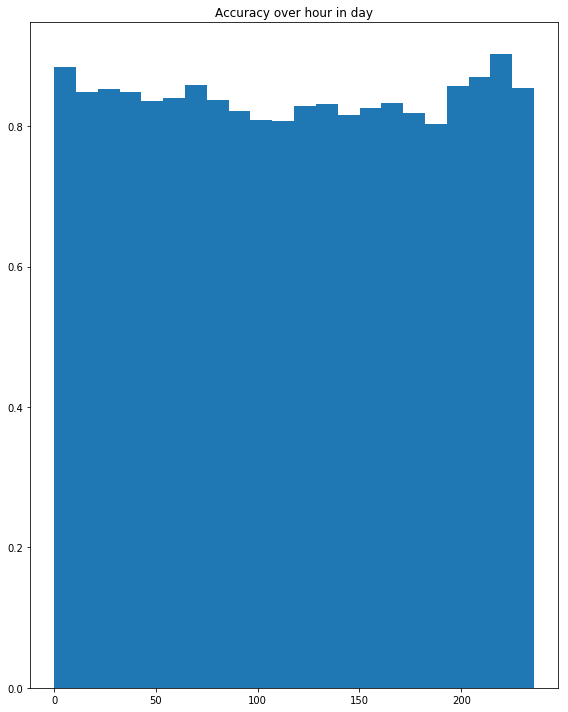

In [ ]:
epoch_num = 10
Label_all = []
Output_all = []
timestamp_all = []
with torch.no_grad():                   # operations inside don't track history

    for mono,encoded,hpss,label,timestamp in test_generator:
        if train_on_gpu:
            mono, encoded, hpss, label, timestamp = mono.unsqueeze(1).cuda(), encoded.cuda(), hpss.cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
  
        outP = ensemble_model(mono, encoded, hpss, timestamp)
        
        Label_all.extend(label.argmax(1).tolist())
        Output_all.extend(outP.argmax(1).tolist())
        timestamp_all.extend(timestamp.tolist())

array = (np.array(Label_all) == np.array(Output_all))
timestamp_all = np.array(timestamp_all)

plt.figure(figsize=(8, 10))
timestamp_false = timestamp_all[np.where(array==False)]
counts_false, bins_false = np.histogram(timestamp_false, bins=22)

timestamp_true = timestamp_all[np.where(array==True)]
counts_true, bins_true = np.histogram(timestamp_true, bins=22)
plt.subplot(1, 1, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.hist(bins_true[:-1], bins_true, weights=counts_true/(counts_true+counts_false))
plt.title('Accuracy over hour in day')
plt.tight_layout()

accuracy = (np.array(Label_all) == np.array(Output_all)).sum() / len(Label_all)
print('Test accuracy: {}%'.format(accuracy * 100))